1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [16]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [9]:
import pandas as pd
import numpy as np

file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name
                   , nrows=1000000
                  )
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
999995,1,0,62,3869209011,2560,29
999996,1,0,51,3869209011,2561,12
999997,1,0,61,3869209011,2562,2
999998,1,0,50,3869209011,2563,4


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [23]:
max_BX=np.max(data["BX_COUNTER"])
print('Number of BX in an ORBIT: ', max_BX)

Number of BX in an ORBIT:  3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [25]:
data["ABS_TIME"]=data["TDC_MEAS"]*25/30+25*data["BX_COUNTER"]+25*max_BX*data["ORBIT_CNT"]
data['ABS_TIME']=data['ABS_TIME']-data.iloc[0,6]
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
999995,1,0,62,3869209011,2560,29,7.877840e+08
999996,1,0,51,3869209011,2561,12,7.877840e+08
999997,1,0,61,3869209011,2562,2,7.877840e+08
999998,1,0,50,3869209011,2563,4,7.877840e+08


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [26]:
data['ABS_TIME'].sort_values(ascending=True)
elapsed_time=pd.to_timedelta(data.iloc[-1,6])

print('Duration of data taking: ', elapsed_time)


Duration of data taking:  0 days 00:00:00.787787149


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [13]:
#COUNTING HOW MANY ROWS A CERTAIN VALUE OF TDC_CHANNEL HAS
TDC_counts=data.groupby(["TDC_CHANNEL"]).size()

#Rearranging in descending order and printing the first three channels
TDC_counts.sort_values(ascending=False).head(3)






TDC_CHANNEL
139    82677
64     50201
63     49335
dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [22]:
#GROUPING BY 'ORBIT_CNT' AND DISPLAYING HOW MANY ROWS FOR ORBIT
ORBIT_counts=data.groupby(["ORBIT_CNT"]).size()

#the vector length is the number of non-empty orbits,
#if there is no measurement in an orbit, 
#that orbit will not appear in the dataset
print('Number of non-empty orbits: ', len(ORBIT_counts)) 


Number of non-empty orbits:  8841


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [15]:
#selecting the group with TDC_CHANNEL == 139
max_TDC_data=data.groupby("TDC_CHANNEL").get_group(139)

#grouping by ORBIT_CNT and seeing how many rows for each Orbit
#remembering we selected data with TDC_CHANNEL == 139
max_TDC_data.groupby(["ORBIT_CNT"]).size()

#As before, the vector length is the number of non-empty orbits
#with TDC_CHANNEL == 139
print(len(max_TDC_data.groupby(["ORBIT_CNT"]).size()))


8816


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [30]:
first_data = data.groupby(['FPGA']).get_group(0)
second_data = data.groupby(['FPGA']).get_group(1)

first_series = first_data.groupby(['TDC_CHANNEL']).size()
second_series = second_data.groupby(['TDC_CHANNEL']).size()

print(first_series, '\n', second_series)

TDC_CHANNEL
1        933
2       1207
3       1156
4       1794
5       1096
       ...  
129        2
130       24
137       23
138       25
139    57878
Length: 124, dtype: int64 
 TDC_CHANNEL
1      21622
2      24871
3      16725
4      20087
5      11375
       ...  
129       26
130       29
137       27
138       27
139    24799
Length: 132, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0.5, 1.0, 'second FPGA')

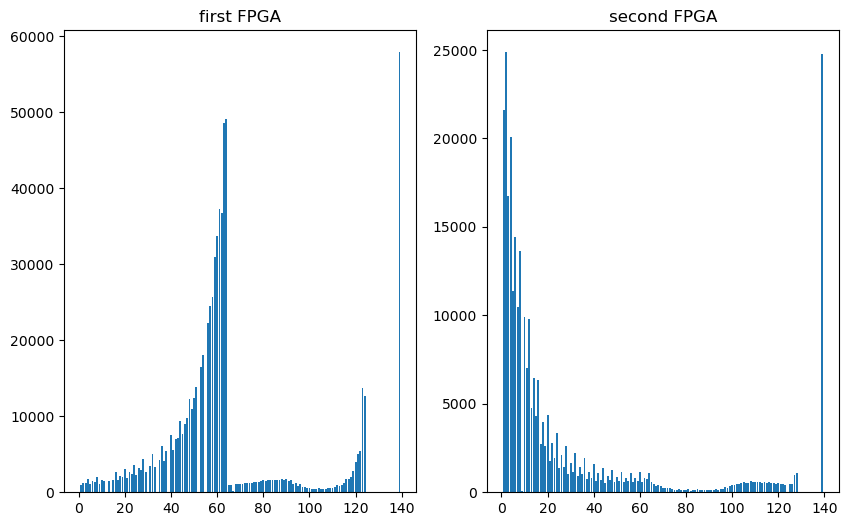

In [43]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10,6))

axes[0].bar(height=first_series, x=first_series.index)
axes[1].bar(height=second_series, x=second_series.index)

axes[0].set_title('first FPGA')
axes[1].set_title('second FPGA')